# Markov Transitions Roberta Large RTE

In [2]:
# Add model_merging to the python path

import os
import sys

model_merging_base = os.path.abspath("../model_merging/")
# assert it exist
assert os.path.exists(model_merging_base)
if model_merging_base not in sys.path:
    sys.path.append(model_merging_base)

In [3]:
# import joblib for caching and distributed computing
from math import sqrt

from joblib import Memory, Parallel, delayed

memory = Memory(location="cache", verbose=10)

parallel = Parallel(n_jobs=2, return_as="generator")
output_generator = parallel(delayed(sqrt)(i**2) for i in range(10))

In [4]:
# Imports and cached functions

import os

from llm_weaver import (
    calculate_score_from_weaving_config,
    test_weaver,
)

# Disable parallelism in tokenizers to avoid deadlocks
os.environ["TOKENIZERS_PARALLELISM"] = "false"

calculate_score_from_weaving_config_cached = memory.cache(
    calculate_score_from_weaving_config
)
test_weaver_cached = memory.cache(test_weaver)

## Step 0: Test weaving code

This test makes sure that our score when using the weaver to reconstruct a model from all its parts get the same evaluation score as the original model

## Steps: configs to graph


In [35]:
from llm_weaver import dict_overwrite, get_model_config, normalize_glue_task_name

model_id = "howey/roberta-large-rte"


def transitions_weave_configs_iter(model_id, trajectories=None, max_configs=None):
    num_original_layers = get_model_config(model_id)["num_hidden_layers"]

    if trajectories is None:
        x_y_layer_sequences = [
            (x, y, (list(range(0, x + 1)) + list(range(y, num_original_layers))))
            for x in range(num_original_layers)
            for y in range(num_original_layers)
        ]
    else:
        x_y_layer_sequences = [(None, None, trajectory) for trajectory in trajectories]

    if max_configs is not None:
        x_y_layer_sequences = x_y_layer_sequences[:max_configs]
    for x, y, layer_sequence in x_y_layer_sequences:
        layer_assignments = [
            {
                "type": "SingleLayer",
                "params": {
                    "donor": model_id,
                    "hidden_layer_number": i,
                },
            }
            for i in layer_sequence
        ]

        blank_model_config = dict_overwrite(
            get_model_config(model_id),
            {
                "num_hidden_layers": len(layer_assignments),
            },
        )
        config = {
            "glue_task": normalize_glue_task_name(model_id),
            "tokenizer_model_id": model_id,
            "blank_model_config": blank_model_config,
            "layer_assignments": layer_assignments,
            "classification_head": {
                "type": "SingleClassificationHead",
                "params": {
                    "donor": model_id,
                },
            },
            "embeddings": {
                "type": "SingleEmbeddings",
                "params": {
                    "donor": model_id,
                },
            },
            "metadata": {
                "x": x,
                "y": y,
            },
        }

        yield config


weave_configs = list(
    transitions_weave_configs_iter(
        model_id=model_id,
    )
)


len(weave_configs)

576

In [36]:
scores = Parallel(n_jobs=5, return_as="list")(
    delayed(calculate_score_from_weaving_config_cached)(
        weave_config,
        # n_examples=4096,
        n_examples=128,
        split="validation",
    )
    for weave_config in weave_configs
)
accuracies = [score["accuracy"] for score in scores]

[Memory]: Loading calculate_score_from_weaving_config from cache/joblib/llm_weaver/calculate_score_from_weaving_config/f3164267ee44d12c7303023e3b426613
[Memory]: Loading calculate_score_from_weaving_config from cache/joblib/llm_weaver/calculate_score_from_weaving_config/1992e0c42f32a3742a4cf0c4e23b8a73
[Memory]: Loading calculate_score_from_weaving_config from cache/joblib/llm_weaver/calculate_score_from_weaving_config/358f2c1464f39ea4cbf53a8723029643
[Memory]: Loading calculate_score_from_weaving_config from cache/joblib/llm_weaver/calculate_score_from_weaving_config/20f7774e2187f21dcd26e168f79c2dcc
[Memory]: Loading calculate_score_from_weaving_config from cache/joblib/llm_weaver/calculate_score_from_weaving_config/dca0dda8eae10b48ee42ab9b7ce9ddf5
_________________calculate_score_from_weaving_config cache loaded - 0.0s, 0.0min
_________________calculate_score_from_weaving_config cache loaded - 0.0s, 0.0min
_________________calculate_score_from_weaving_config cache loaded - 0.0s, 0.0m

<Axes: xlabel='y', ylabel='x'>

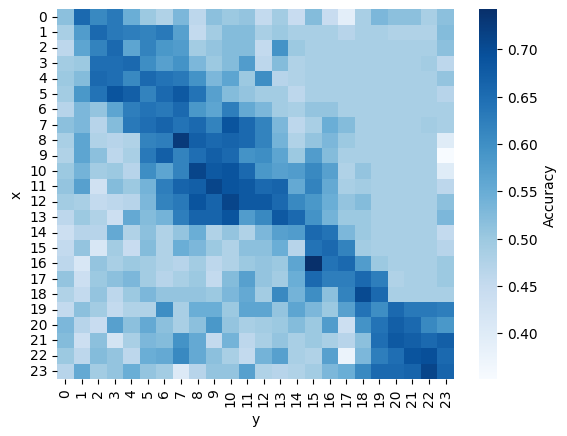

In [37]:
import pandas as pd

records = []
for weave_config, accuracy in zip(weave_configs, accuracies):
    record = weave_config["metadata"]
    record["accuracy"] = accuracy
    records.append(record)
df_big_grid = pd.DataFrame.from_records(records)

# Plot a heatmap of the accuracy with respect to the layer transitions
# x and y are the layer numbers of the first and last layer of the transition
# the color is the accuracy

import seaborn as sns

sns.heatmap(
    df_big_grid.pivot(index="x", columns="y", values="accuracy"),
    # annot=True,
    # fmt=".0%",
    # do not show numbers in the heatmap
    # fmt=".0f",
    cmap="Blues",
    cbar_kws={"label": "Accuracy"},
)

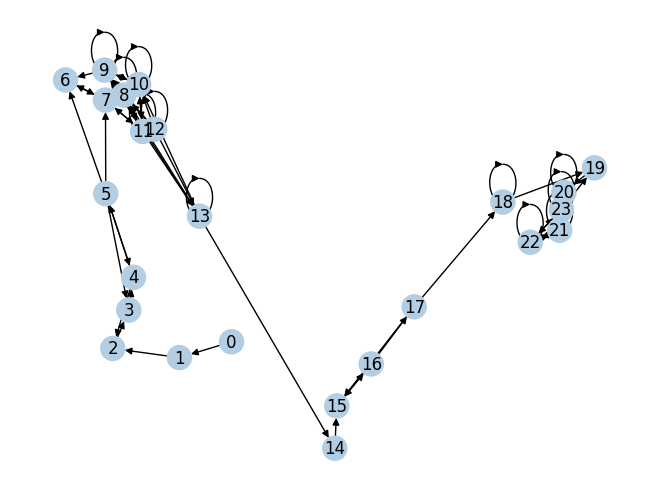

In [41]:
num_layers = get_model_config(model_id)["num_hidden_layers"]

import networkx as nx

G = nx.DiGraph()
G.add_nodes_from(range(num_layers))

weights = (
    df_big_grid.pivot(index="x", columns="y", values="accuracy").fillna(0).to_numpy()
)
max_weight = weights.max()

for x in range(num_layers):
    for y in range(num_layers):
        # if the weight is > 0.7, add the edge
        print(max_weight - 0.09)
        if weights[x][y] > max_weight - 0.09:
            G.add_edge(x, y, weight=weights[x][y])

# light blue nodes
node_colors = ["#b3cde3"] * num_layers
nx.draw(G, with_labels=True, node_color=node_colors)

In [42]:
# Sample trajectories
import random

random.seed(42)

trajectories_by_length = {}
for length in range(num_layers - 2, num_layers + 7):
    trajectories = []
    while len(trajectories) < 5:
        trajectory = [0]
        while trajectory[-1] != num_layers - 1:
            # Assume uniform distribution over neighbors
            trajectory.append(random.choice(list(G.neighbors(trajectory[-1]))))
        if len(trajectory) == length:
            trajectories.append(trajectory)
    trajectories_by_length[length] = trajectories

print(trajectories_by_length)

{22: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 13, 14, 15, 16, 15, 16, 17, 18, 19, 20, 21, 23], [0, 1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 20, 21, 22, 23], [0, 1, 2, 3, 4, 5, 7, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 20, 20, 21, 22, 23], [0, 1, 2, 3, 4, 5, 6, 7, 11, 13, 14, 15, 16, 17, 18, 19, 20, 20, 21, 22, 22, 23], [0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 13, 14, 15, 16, 17, 18, 19, 20, 20, 21, 21, 23]], 23: [[0, 1, 2, 3, 4, 2, 3, 4, 5, 6, 7, 11, 13, 14, 15, 16, 17, 18, 18, 19, 20, 21, 23], [0, 1, 2, 3, 4, 5, 3, 4, 5, 6, 7, 8, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23], [0, 1, 2, 3, 4, 2, 3, 4, 5, 7, 6, 7, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23], [0, 1, 2, 3, 4, 2, 3, 4, 5, 7, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 20, 21, 23], [0, 1, 2, 3, 4, 5, 4, 5, 6, 7, 11, 13, 13, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23]], 24: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 7, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 20, 20, 21, 23], [0, 1, 2, 3, 4, 5, 7, 11, 13, 14, 15, 16, 15, 16, 15, 16, 17, 18, 18, 

In [43]:
records = []

for length, trajectories in trajectories_by_length.items():
    print(f"Length {length}")
    weave_configs = list(
        transitions_weave_configs_iter(model_id, trajectories=trajectories)
    )

    scores = Parallel(n_jobs=5, return_as="list")(
        delayed(calculate_score_from_weaving_config_cached)(
            weave_config,
            # n_examples=4096,
            n_examples=128,
            split="validation",
        )
        for weave_config in weave_configs
    )
    accuracies = [score["accuracy"] for score in scores]

    for trajectory, accuracy in zip(trajectories, accuracies):
        record = {}
        record["trajectory"] = trajectory
        record["accuracy"] = accuracy
        record["trajectory_length"] = len(trajectory)
        records.append(record)
df_transitions = pd.DataFrame.from_records(records)
df_transitions

Length 22
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validation')
calculating score for weaving config md5sum: 1794ebff5ab2921fa374

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
Some weights of the PyTorch model were not used when initializing the TF 2.0 mode

_____________________________calculate_score_from_weaving_config - 92.4s, 1.5min
_____________________________calculate_score_from_weaving_config - 96.5s, 1.6min
_____________________________calculate_score_from_weaving_config - 97.4s, 1.6min
_____________________________calculate_score_from_weaving_config - 98.7s, 1.6min
_____________________________calculate_score_from_weaving_config - 98.7s, 1.6min
Length 23


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validation')
___________________________________________________________________________

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
Some weights of the PyTorch model were not used when initializing the TF 2.0 mode

2023-11-28 06:41:40.091995: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2023-11-28 06:41:41.113108: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 06:41:41.366793: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 06:41:41.509343: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. I

_____________________________calculate_score_from_weaving_config - 91.6s, 1.5min
_____________________________calculate_score_from_weaving_config - 94.0s, 1.6min
_____________________________calculate_score_from_weaving_config - 94.1s, 1.6min
_____________________________calculate_score_from_weaving_config - 94.5s, 1.6min
_____________________________calculate_score_from_weaving_config - 94.7s, 1.6min
Length 24
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

2023-11-28 06:43:08.908466: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 06:43:08.927905: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 06:43:08.934272: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. I

_____________________________calculate_score_from_weaving_config - 86.1s, 1.4min
_____________________________calculate_score_from_weaving_config - 88.7s, 1.5min
_____________________________calculate_score_from_weaving_config - 89.4s, 1.5min
_____________________________calculate_score_from_weaving_config - 89.5s, 1.5min
_____________________________calculate_score_from_weaving_config - 89.2s, 1.5min
Length 25
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

_____________________________calculate_score_from_weaving_config - 87.3s, 1.5min
_____________________________calculate_score_from_weaving_config - 89.5s, 1.5min
_____________________________calculate_score_from_weaving_config - 90.1s, 1.5min
_____________________________calculate_score_from_weaving_config - 90.4s, 1.5min
_____________________________calculate_score_from_weaving_config - 90.6s, 1.5min
Length 26
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

2023-11-28 06:46:11.241275: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 06:46:12.380708: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 06:46:13.414587: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. I

_____________________________calculate_score_from_weaving_config - 94.5s, 1.6min
_____________________________calculate_score_from_weaving_config - 95.0s, 1.6min
_____________________________calculate_score_from_weaving_config - 96.1s, 1.6min
_____________________________calculate_score_from_weaving_config - 96.4s, 1.6min
_____________________________calculate_score_from_weaving_config - 96.9s, 1.6min
Length 27
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

_____________________________calculate_score_from_weaving_config - 98.4s, 1.6min
_____________________________calculate_score_from_weaving_config - 99.6s, 1.7min
_____________________________calculate_score_from_weaving_config - 99.6s, 1.7min
____________________________calculate_score_from_weaving_config - 100.4s, 1.7min
____________________________calculate_score_from_weaving_config - 100.8s, 1.7min
Length 28
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

____________________________calculate_score_from_weaving_config - 103.0s, 1.7min
____________________________calculate_score_from_weaving_config - 106.6s, 1.8min
____________________________calculate_score_from_weaving_config - 106.7s, 1.8min
____________________________calculate_score_from_weaving_config - 106.8s, 1.8min
____________________________calculate_score_from_weaving_config - 107.2s, 1.8min
Length 29
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

____________________________calculate_score_from_weaving_config - 107.4s, 1.8min
____________________________calculate_score_from_weaving_config - 108.5s, 1.8min
____________________________calculate_score_from_weaving_config - 109.6s, 1.8min
____________________________calculate_score_from_weaving_config - 109.6s, 1.8min
____________________________calculate_score_from_weaving_config - 109.6s, 1.8min
Length 30
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

2023-11-28 06:53:16.631194: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2023-11-28 06:53:17.629211: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 06:53:17.671686: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 06:53:18.243264: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. I

____________________________calculate_score_from_weaving_config - 107.8s, 1.8min
____________________________calculate_score_from_weaving_config - 111.2s, 1.9min
____________________________calculate_score_from_weaving_config - 112.0s, 1.9min
____________________________calculate_score_from_weaving_config - 112.0s, 1.9min
____________________________calculate_score_from_weaving_config - 112.1s, 1.9min


,trajectory,accuracy,trajectory_length
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 13, 14, 15, 16...",0.601562,22
1,"[0, 1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 1...",0.640625,22
2,"[0, 1, 2, 3, 4, 5, 7, 11, 13, 14, 15, 16, 17, ...",0.515625,22
3,"[0, 1, 2, 3, 4, 5, 6, 7, 11, 13, 14, 15, 16, 1...",0.554688,22
4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 13, 14, 15, 16...",0.539062,22
5,"[0, 1, 2, 3, 4, 2, 3, 4, 5, 6, 7, 11, 13, 14, ...",0.523438,23
6,"[0, 1, 2, 3, 4, 5, 3, 4, 5, 6, 7, 8, 11, 13, 1...",0.515625,23
7,"[0, 1, 2, 3, 4, 2, 3, 4, 5, 7, 6, 7, 11, 13, 1...",0.460938,23
8,"[0, 1, 2, 3, 4, 2, 3, 4, 5, 7, 11, 13, 14, 15,...",0.484375,23
9,"[0, 1, 2, 3, 4, 5, 4, 5, 6, 7, 11, 13, 13, 13,...",0.476562,23


<Axes: xlabel='trajectory_length', ylabel='accuracy'>

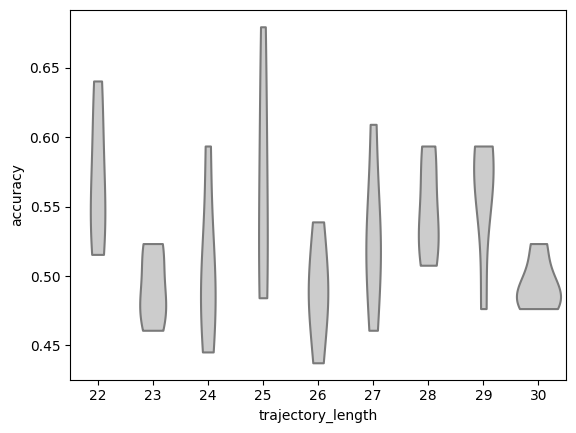

In [44]:
# Show a violin plot of the distribution of accuracies for each trajectory length
sns.violinplot(
    data=df_transitions,
    x="trajectory_length",
    y="accuracy",
    inner=None,
    color=".8",
    cut=0,
)